In [1]:
import pandas as pd
import numpy as np
from py_files.data_manager import get_X_y
from py_files.features import distance, generate_features
from config import data_path

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error
import time
import xgboost as xgb
pd.options.display.float_format = '{:.6f}'.format

In [ ]:
# X, y = get_X_y(force_clean=True)
X, y = get_X_y()
X = generate_features(X)
X['pickup_datetime'] = pd.to_datetime(X['pickup_datetime'])

In [4]:
d = pd.read_csv(data_path + '/train_clean.csv')
d

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,pickup_month,...,pickup_day_Tuesday,pickup_day_Wednesday,pickup_hour,pickup_minute,pickup_period_morning,pickup_period_afternoon,pickup_period_evening,pickup_hour_sin,pickup_hour_cos,pickup_datetime_norm
0,id2875421,1,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,455,3,...,0,0,17,24,0,1,0,-0.965926,-0.258819,0.405086
1,id2377394,0,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,663,6,...,0,0,0,43,0,0,0,0.000000,1.000000,0.895772
2,id3858529,1,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,2124,1,...,1,0,11,35,1,0,0,0.258819,-0.965926,0.101554
3,id3504673,1,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,429,4,...,0,1,19,32,0,0,1,-0.965926,0.258819,0.531947
4,id2181028,1,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,435,3,...,0,0,13,30,0,1,0,-0.258819,-0.965926,0.470127
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,1,2016-04-08 13:31:04,4,-73.982201,40.745522,-73.994911,40.740170,778,4,...,0,0,13,31,0,1,0,-0.258819,-0.965926,0.541556
1458640,id1049543,0,2016-01-10 07:35:15,1,-74.000946,40.747379,-73.970184,40.796547,655,1,...,0,0,7,35,1,0,0,0.965926,-0.258819,0.051187
1458641,id2304944,1,2016-04-22 06:57:41,1,-73.959129,40.768799,-74.004433,40.707371,764,4,...,0,0,6,57,0,0,0,1.000000,0.000000,0.616979
1458642,id2714485,0,2016-01-05 15:56:26,1,-73.982079,40.749062,-73.974632,40.757107,373,1,...,1,0,15,56,0,1,0,-0.707107,-0.707107,0.025626


In [21]:
X.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'pickup_month', 'pickup_day_Monday',
       'pickup_day_Saturday', 'pickup_day_Sunday', 'pickup_day_Thursday',
       'pickup_day_Tuesday', 'pickup_day_Wednesday', 'pickup_hour',
       'pickup_minute', 'pickup_period_morning', 'pickup_period_afternoon',
       'pickup_period_evening', 'pickup_hour_sin', 'pickup_hour_cos',
       'pickup_datetime_norm', 'distance_km', 'temperature_2m (°C)',
       'precipitation (mm)', 'cloudcover (%)'],
      dtype='object')

In [41]:
# Keep only pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, pickup_month, pickup_hour, pickup_period, distance
# X_c = X[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
#             'pickup_month', 'pickup_hour', 'pickup_period', 'distance_km']]
# X_c = pd.get_dummies(X_c, columns=['pickup_period'], drop_first=True)
# X = X.drop(columns=['id', 'pickup_datetime'])

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, np.log(y), test_size=0.2, random_state=42)

# Train model
model = RandomForestRegressor(n_estimators=100, max_depth=6, n_jobs=1, random_state=42, verbose=1)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)
print(mean_squared_log_error(y_test, y_pred, squared=False))


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  6.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.11470396973073911


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished


In [42]:
np.sqrt(np.mean((np.log(y_pred + 1) - np.log(y_test + 1))**2))

0.11470396973073946

In [36]:
# Try log transformation of y
y_log = np.log(y)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)

# Run xgboost regressor on the data.
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=6, n_jobs=1, random_state=42)
xgb_reg.fit(X_train, y_train)

# Predict
y_pred = xgb_reg.predict(X_test)
print(mean_squared_log_error(y_test, y_pred, squared=True))

0.11481842658070009


In [39]:
print(mean_squared_log_error(y_test, y_pred, squared=False))

0.11481842658070009


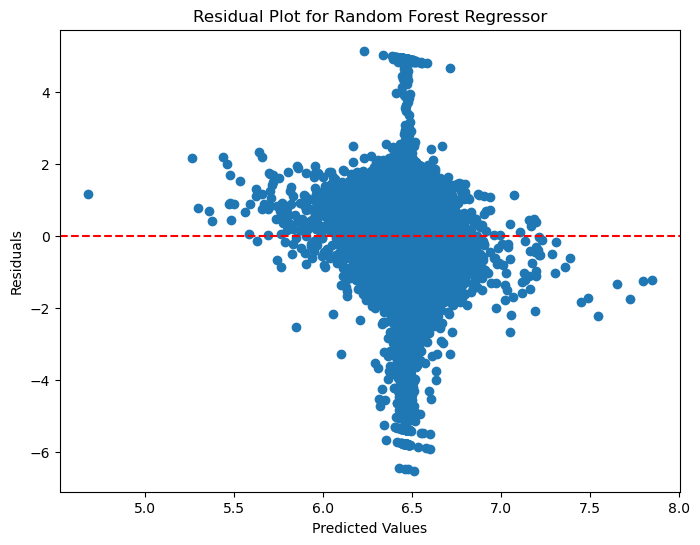

In [40]:
# Calculate residuals
residuals = y_test - y_pred

# Create a residual plot
plt.figure(figsize=(8, 6))
plt.scatter(x=y_pred, y=residuals)
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot for Random Forest Regressor")
plt.show()

In [81]:
# Train test split
X_c = X.drop(columns=['pickup_datetime'])
X_c = pd.get_dummies(X_c, columns=['pickup_period'], drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(X_c, y, test_size=0.2, random_state=42)

# Grid search for XGBoost
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [6, 8],
    'learning_rate': [0.1, 0.2],
    'min_child_weight': [1, 2],
    'lambda': [0.5, 0.4],
    'alpha': [0.5, 0.4],
    'objective': ['reg:squarederror', 'reg:squaredlogerror']
}
xgb_model = xgb.XGBRegressor()

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=4, n_jobs=-1)
grid_search.fit(X_train, y_train)



# Evaluate based on Root Mean Squared Logarithmic Error.
y_pred = grid_search.predict(X_test)
print(mean_squared_log_error(y_test, y_pred, squared=False))


0.525662602679601


<h3>Doing some basic data analysis</h3>

Task:
<ul>
<li>✅ Get most common pickup and dropoff locations.</li>
<li>Find the number of rows and columns</li>
<li>Find the data statistics</li>
</ul>

In [49]:
# Get the most common pickup longitude and latitude
pop_p_lat = X_c.pickup_latitude.value_counts().index[0]
pop_p_long = X_c[X_c.pickup_latitude == pop_p_lat].pickup_longitude.value_counts().index[0]

# Most common pickup location
com_pickup = (pop_p_lat, pop_p_long)  # This is actually the airport, so that makes sense.

# Get the most common dropoff latitude and longitude 
pop_d_lat = X_c.dropoff_latitude.value_counts().index[0]
pop_d_long = X_c[X_c.dropoff_latitude == pop_d_lat].dropoff_longitude.value_counts().index[0]

# Most common dropoff location
com_dropoff = (pop_d_lat, pop_d_long)  # This is actually the airport, so that makes sense.
com_dropoff

(40.774311, -73.872787)

In [53]:
# Find most common drop off location when pickup location is the airport
drop_lat_after_aiport = X_c[(X_c.pickup_latitude == pop_p_lat) & (X_c.pickup_longitude == pop_p_long)].dropoff_latitude.value_counts()#.index[0]
# drop_long_after_aiport = X_c[X_c.pickup_latitude == pop_p_lat][X_c.dropoff_latitude == drop_lat_after_aiport].dropoff_longitude.value_counts().index[0]
drop_lat_after_aiport

40.668980    1
40.673012    1
40.757832    1
40.642849    1
40.762131    1
40.738796    1
40.750011    1
40.783730    1
40.691589    1
40.802757    1
40.758480    1
40.770809    1
Name: dropoff_latitude, dtype: int64

<h2>Trying to get actual distance between points</h2>

Unfortunantely, this takes forever...

In [30]:
# Get subset.
test = X[['id','pickup_datetime','pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'google_distance']]

# Use the TomTom api to get the distance between the pickup and dropoff locations.
import requests

api_key = 'P4yc5kzx2Af9vNSAlweNe6AaHTgzEvDA'

def get_driving_distance(api_key, origin, destination):
    # TomTom Routing API endpoint for calculating routes
    endpoint = "https://api.tomtom.com/routing/1/calculateRoute/"

    # Build the request URL
    url = f"{endpoint}{origin['lat']},{origin['lon']}:{destination['lat']},{destination['lon']}/json"

    # Add API key to the request parameters
    params = {"key": api_key}

    # Make the API request
    response = requests.get(url, params=params)

    response.raise_for_status()  # raises exception when not a 2xx response
    if response.status_code != 204:
        return response.json()

    # Parse the JSON response
    data = response.json()

    # Extract the driving distance from the response
    try:
        distance = data["routes"][0]["summary"]["lengthInMeters"]
        return distance
    except (KeyError, IndexError):
        print("Error: Unable to retrieve driving distance.")
        return None

def calculate_distance(row):
    origin = {"lat": row["pickup_latitude"], "lon": row["pickup_longitude"]}
    destination = {"lat": row["dropoff_latitude"], "lon": row["dropoff_longitude"]}
    distance = get_driving_distance(api_key, origin, destination)
    return distance if distance is not None else None

# Get the distance between the pickup and dropoff locations.

# Test tomtom api by getting distance between two points.
test_feb = test[test['pickup_datetime'].month == 2]
test['tomtom_distance'] = test[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']].apply(calculate_distance, axis=1)

HTTPError: 429 Client Error: Too Many Requests for url: https://api.tomtom.com/routing/1/calculateRoute/40.7662239074707,-73.9696273803711:40.7625732421875,-73.97447204589844/json?key=P4yc5kzx2Af9vNSAlweNe6AaHTgzEvDA